Generate plots based on parametric dataset (compare 4 methods)

In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import joypy

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'results\\synthetic\\dataset\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'

fig_folder = project_folder_path + 'results\\synthetic\\fig_drafts_paper\\'

In [3]:
save_fig = False

### Load data

In [4]:
with open(dataset_folder + '1_spike_trains_3params_var_len600sec_100000.pkl','rb') as f:
    data = pickle.load(f)

spike_trains = data['spike_trains']
alphas = data['alphas']
fr_values = data['fr_values']
taus_ms = data['tau_ms']
duration_ms = data['duration_ms']

print(f'n spike trains {len(spike_trains)}, len {spike_trains[0][-1]/1000}, duration_ms {duration_ms}')

n spike trains 100000, len 598.8243581617338, duration_ms 600000


In [5]:
with open(results_folder + 'acf_isttc_full_50ms_20lags_dict.pkl', "rb") as f:
    isttc_full_dict = pickle.load(f)

with open(results_folder + 'acf_full_50ms_20lags_dict.pkl', "rb") as f:
    acf_full_dict = pickle.load(f)

with open(results_folder + 'pearsonr_trial_avg_50ms_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_avg_50ms_dict.pkl', "rb") as f:
    sttc_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_concat_50ms_dict.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

print(f'len isttc_full_dict {len(isttc_full_dict)}')
print(f'len acf_full_dict {len(acf_full_dict)}')
print(f'len pearsonr_trial_avg_dict {len(pearsonr_trial_avg_dict)}')
print(f'len sttc_trial_avg_dict {len(sttc_trial_avg_dict)}')
print(f'len sttc_trial_concat_dict {len(sttc_trial_concat_dict)}')

len isttc_full_dict 100000
len acf_full_dict 100000
len pearsonr_trial_avg_dict 100000
len sttc_trial_avg_dict 100000
len sttc_trial_concat_dict 100000


### Make summary dfs

In [6]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [7]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

In [8]:
def get_trials_plot_df(trial_dict_, method_, n_iteration_=None):
    records = []
    for unit_id, data in trial_dict_.items():
        taus = data['taus']
        acfs = data['acf']

        if n_iteration_ is not None:
            # only one trial per unit
            idx = n_iteration_[unit_id]
            taus_to_iter = [(taus[idx], acfs[idx])]
        else:
            # all trials for this unit
            taus_to_iter = zip(taus, acfs)

        for tau_dict, acf_array in taus_to_iter:
            records.append({
                'unit_id': unit_id,
                'tau': tau_dict['tau'],
                'fit_r_squared': tau_dict['fit_r_squared'],
                'decline_150_250': calculate_acf_decline_flag(acf_array, start_idx=2, end_idx=4),
                'method': method_,
            })

    df = pd.DataFrame.from_records(records)
    df['tau_ms'] = df['tau'] * 50

    nan_count = df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}')

    return df

In [9]:
data = []
for unit_id, unit_data in acf_full_dict.items():
    taus = unit_data['taus']  
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'tau_lower': taus['tau_lower'],
        'tau_upper': taus['tau_upper'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
acf_full_plot_df = pd.DataFrame(data)
acf_full_plot_df['tau_ms'] = acf_full_plot_df['tau'] * 50

rows_with_nans_df = acf_full_plot_df[acf_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')
acf_full_plot_df['method'] = 'acf_full'
acf_full_plot_df['fr'] = fr_values
acf_full_plot_df['alpha'] = alphas
acf_full_plot_df['tau_ms_true'] = taus_ms
acf_full_plot_df['tau_diff_abs'] = np.abs(acf_full_plot_df['tau_ms'] - acf_full_plot_df['tau_ms_true'])
acf_full_plot_df['tau_diff_rel'] = acf_full_plot_df['tau_diff_abs'] / acf_full_plot_df['tau_ms_true'] * 100

acf_full_plot_df.head(2)

N rows with NaNs 11


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,tau_ms,method,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel
0,0,2.217899,2.119224,2.316575,0.998369,True,110.894975,acf_full,7.741821,0.851099,150.923515,40.028540,26.522401
1,1,2.568210,2.437150,2.699270,0.997899,True,128.410512,acf_full,4.394396,0.858098,147.947233,19.536721,13.205195


In [10]:
data = []
for unit_id, unit_data in isttc_full_dict.items():
    taus = unit_data['taus']      
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'tau_lower': taus['tau_lower'],
        'tau_upper': taus['tau_upper'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
isttc_full_plot_df = pd.DataFrame(data)
isttc_full_plot_df['method'] = 'isttc_full'
isttc_full_plot_df['tau_ms'] = isttc_full_plot_df['tau'] * 50

rows_with_nans_df = isttc_full_plot_df[isttc_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')

isttc_full_plot_df['method'] = 'isttc_full'
isttc_full_plot_df['fr'] = fr_values
isttc_full_plot_df['alpha'] = alphas
isttc_full_plot_df['tau_ms_true'] = taus_ms
isttc_full_plot_df['tau_diff_abs'] = np.abs(isttc_full_plot_df['tau_ms'] - isttc_full_plot_df['tau_ms_true'])
isttc_full_plot_df['tau_diff_rel'] = isttc_full_plot_df['tau_diff_abs'] / isttc_full_plot_df['tau_ms_true'] * 100

isttc_full_plot_df.head(2)

N rows with NaNs 0


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel
0,0,2.523412,2.362379,2.684445,0.996707,True,isttc_full,126.170618,7.741821,0.851099,150.923515,24.752897,16.400954
1,1,2.834326,2.688470,2.980182,0.997916,True,isttc_full,141.716309,4.394396,0.858098,147.947233,6.230924,4.211585


In [11]:
# for trial based measures one realization of trials is taken
random_trials_impl = np.zeros(len(sttc_trial_concat_dict)).astype(int)

pearsontr_trial_avg_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg', random_trials_impl)
sttc_trial_concat_plot_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat', random_trials_impl)
sttc_trial_avg_plot_df = get_trials_plot_df(sttc_trial_avg_dict, 'sttc_trial_avg', random_trials_impl)

pearsontr_trial_avg_plot_df['fr'] = fr_values
pearsontr_trial_avg_plot_df['alpha'] = alphas
pearsontr_trial_avg_plot_df['tau_ms_true'] = taus_ms
pearsontr_trial_avg_plot_df['tau_diff_abs'] = np.abs(pearsontr_trial_avg_plot_df['tau_ms'] - pearsontr_trial_avg_plot_df['tau_ms_true'])
pearsontr_trial_avg_plot_df['tau_diff_rel'] = pearsontr_trial_avg_plot_df['tau_diff_abs'] / pearsontr_trial_avg_plot_df['tau_ms_true'] * 100

sttc_trial_concat_plot_df['fr'] = fr_values
sttc_trial_concat_plot_df['alpha'] = alphas
sttc_trial_concat_plot_df['tau_ms_true'] = taus_ms
sttc_trial_concat_plot_df['tau_diff_abs'] = np.abs(sttc_trial_concat_plot_df['tau_ms'] - sttc_trial_concat_plot_df['tau_ms_true'])
sttc_trial_concat_plot_df['tau_diff_rel'] = sttc_trial_concat_plot_df['tau_diff_abs'] / sttc_trial_concat_plot_df['tau_ms_true'] * 100

sttc_trial_avg_plot_df['fr'] = fr_values
sttc_trial_avg_plot_df['alpha'] = alphas
sttc_trial_avg_plot_df['tau_ms_true'] = taus_ms
sttc_trial_avg_plot_df['tau_diff_abs'] = np.abs(sttc_trial_avg_plot_df['tau_ms'] - sttc_trial_avg_plot_df['tau_ms_true'])
sttc_trial_avg_plot_df['tau_diff_rel'] = sttc_trial_avg_plot_df['tau_diff_abs'] / sttc_trial_avg_plot_df['tau_ms_true'] * 100

N rows with NaNs 12393


In [12]:
# check for NaNs and for a long df remove rows with NaNs (if for a unit one method failed than remove it)

rows_with_nans_acf_df = acf_full_plot_df[acf_full_plot_df.isna().any(axis=1)]
n_rows_with_nan_acf = len(rows_with_nans_acf_df)
print(f'N rows with NaNs {n_rows_with_nan_acf}')

rows_with_nans_isttc_df = isttc_full_plot_df[isttc_full_plot_df.isna().any(axis=1)]
n_rows_with_nan_isttc = len(rows_with_nans_isttc_df)
print(f'N rows with NaNs {n_rows_with_nan_isttc}')

# # take from isttc dataset only rows where acf df has no NaNs
# isttc_full_plot_df = isttc_full_plot_df[~isttc_full_plot_df['unit_id'].isin(rows_with_nans_acf_df['unit_id'].values)]
# acf_full_plot_df = acf_full_plot_df[~acf_full_plot_df['unit_id'].isin(rows_with_nans_acf_df['unit_id'].values)]

# print(f'len acf_full_plot_df {len(acf_full_plot_df)}, len isttc_full_plot_df {len(isttc_full_plot_df)}')

rows_with_nans_pearsonr_df = pearsontr_trial_avg_plot_df[pearsontr_trial_avg_plot_df.isna().any(axis=1)]
n_rows_with_nan_pearsonr = len(rows_with_nans_pearsonr_df)
print(f'N rows with NaNs {n_rows_with_nan_pearsonr}')

rows_with_nans_isttc_concat_df = sttc_trial_concat_plot_df[sttc_trial_concat_plot_df.isna().any(axis=1)]
n_rows_with_nan_isttc_concat = len(rows_with_nans_isttc_concat_df)
print(f'N rows with NaNs {n_rows_with_nan_isttc_concat}')

rows_with_nans_isttc_avg_df = sttc_trial_avg_plot_df[sttc_trial_avg_plot_df.isna().any(axis=1)]
n_rows_with_nan_isttc_avg = len(rows_with_nans_isttc_avg_df)
print(f'N rows with NaNs {n_rows_with_nan_isttc_avg}')

acf_nan_unit_ids = rows_with_nans_acf_df['unit_id'].values
isttc_nan_unit_ids = rows_with_nans_isttc_df['unit_id'].values
pearsonr_nan_unit_ids = rows_with_nans_pearsonr_df['unit_id'].values
sttc_concat_nan_unit_ids = rows_with_nans_isttc_concat_df['unit_id'].values
sttc_avg_nan_unit_ids = rows_with_nans_isttc_avg_df['unit_id'].values

unit_ids_nan_union = set(pearsonr_nan_unit_ids).union(sttc_concat_nan_unit_ids).union(sttc_avg_nan_unit_ids).union(acf_nan_unit_ids).union(isttc_nan_unit_ids)
print(f'N rows in unit_ids_nan_union {len(unit_ids_nan_union)}')

# take rows without NaNs
acf_sans_nans_plot_df = acf_full_plot_df[~acf_full_plot_df['unit_id'].isin(unit_ids_nan_union)]
isttc_sans_nans_plot_df = isttc_full_plot_df[~isttc_full_plot_df['unit_id'].isin(unit_ids_nan_union)]
pearsonr_sans_nans_plot_df = pearsontr_trial_avg_plot_df[~pearsontr_trial_avg_plot_df['unit_id'].isin(unit_ids_nan_union)]
sttc_concat_sans_nans_plot_df = sttc_trial_concat_plot_df[~sttc_trial_concat_plot_df['unit_id'].isin(unit_ids_nan_union)]
sttc_avg_sans_nans_plot_df = sttc_trial_avg_plot_df[~sttc_trial_avg_plot_df['unit_id'].isin(unit_ids_nan_union)]

print(f'len pearsonr {len(pearsonr_sans_nans_plot_df)}, len sttc_concat {len(sttc_concat_sans_nans_plot_df)}, len sttc_avg {len(sttc_avg_sans_nans_plot_df)}')
print(f'len acf {len(acf_sans_nans_plot_df)}, len isttc {len(isttc_sans_nans_plot_df)}')

N rows with NaNs 11
N rows with NaNs 0
N rows with NaNs 12393
N rows with NaNs 0
N rows with NaNs 0
N rows in unit_ids_nan_union 12393
len pearsonr 87607, len sttc_concat 87607, len sttc_avg 87607
len acf 87607, len isttc 87607


In [13]:
# check for negative R-square

rows_with_negr_acf_df = acf_full_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_acf = len(rows_with_negr_acf_df)
print(f'N rows with neg R {n_rows_with_negr_acf}')

rows_with_negr_isttc_df = isttc_full_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_isttc = len(rows_with_negr_isttc_df)
print(f'N rows with neg R {n_rows_with_negr_isttc}')

rows_with_negr_pearsonr_df = pearsonr_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_pearsonr = len(rows_with_negr_pearsonr_df)
print(f'N rows with neg R {n_rows_with_negr_pearsonr}')

rows_with_negr_isttc_concat_df = sttc_concat_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_isttc_concat = len(rows_with_negr_isttc_concat_df)
print(f'N rows with neg R {n_rows_with_negr_isttc_concat}')

rows_with_negr_isttc_avg_df = sttc_avg_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_isttc_avg = len(rows_with_negr_isttc_avg_df)
print(f'N rows with neg R {n_rows_with_negr_isttc_avg}')

acf_negr_unit_ids = rows_with_negr_acf_df['unit_id'].values
isttc_negr_unit_ids = rows_with_negr_isttc_df['unit_id'].values
pearsonr_negr_unit_ids = rows_with_negr_pearsonr_df['unit_id'].values
isttc_concat_negr_unit_ids = rows_with_negr_isttc_concat_df['unit_id'].values
isttc_avg_negr_unit_ids = rows_with_negr_isttc_avg_df['unit_id'].values

unit_ids_negr_union = set(pearsonr_negr_unit_ids).union(isttc_concat_negr_unit_ids).union(isttc_avg_negr_unit_ids).union(acf_negr_unit_ids).union(isttc_negr_unit_ids)
print(f'N rows in unit_ids_negr_union {len(unit_ids_negr_union)}')

isttc_sans_negr_plot_df = isttc_sans_nans_plot_df[~isttc_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
acf_sans_negr_plot_df = acf_sans_nans_plot_df[~acf_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
pearsonr_sans_negr_plot_df = pearsonr_sans_nans_plot_df[~pearsonr_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
sttc_concat_sans_negr_plot_df = sttc_concat_sans_nans_plot_df[~sttc_concat_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
sttc_avg_sans_negr_plot_df = sttc_avg_sans_nans_plot_df[~sttc_avg_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()

acf_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(acf_sans_negr_plot_df['tau_diff_rel'])
isttc_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(isttc_sans_negr_plot_df['tau_diff_rel'])
pearsonr_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(pearsonr_sans_negr_plot_df['tau_diff_rel'])
sttc_concat_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(sttc_concat_sans_negr_plot_df['tau_diff_rel'])
sttc_avg_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(sttc_avg_sans_negr_plot_df['tau_diff_rel'])

print(f'len pearsonr {len(pearsonr_sans_negr_plot_df)}, len sttc_concat {len(sttc_concat_sans_negr_plot_df)}, len sttc_avg {len(sttc_avg_sans_negr_plot_df)}')
print(f'len acf {len(acf_sans_negr_plot_df)}, len isttc {len(isttc_sans_negr_plot_df)}')

N rows with neg R 237
N rows with neg R 238
N rows with neg R 4201
N rows with neg R 4295
N rows with neg R 4479
N rows in unit_ids_negr_union 6892
len pearsonr 80893, len sttc_concat 80893, len sttc_avg 80893
len acf 80893, len isttc 80893


In [ ]:
acf_sans_negr_plot_df.head(2)

In [14]:
tau_plot_long_df = pd.concat([acf_sans_negr_plot_df, isttc_sans_negr_plot_df, 
                              pearsonr_sans_negr_plot_df, 
                              sttc_concat_sans_negr_plot_df, 
                              sttc_avg_sans_negr_plot_df])
tau_plot_long_df['log_tau_ms'] = np.log10(tau_plot_long_df['tau_ms'])
tau_plot_long_df.reset_index(inplace=True, drop=True)

print(f'len tau_plot_long_df {len(tau_plot_long_df)}')

tau_plot_long_df.head(3)

len tau_plot_long_df 404465


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,tau_ms,method,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,tau_diff_rel_log10,log_tau_ms
0,0,2.217899,2.119224,2.316575,0.998369,True,110.894975,acf_full,7.741821,0.851099,150.923515,40.028540,26.522401,1.423613,2.044912
1,1,2.568210,2.437150,2.699270,0.997899,True,128.410512,acf_full,4.394396,0.858098,147.947233,19.536721,13.205195,1.120745,2.108601
2,2,5.227451,4.334421,6.120482,0.984960,True,261.372568,acf_full,8.587393,0.528805,267.002290,5.629722,2.108492,0.323972,2.417260


In [15]:
tau_plot_long_df = pd.concat([acf_sans_negr_plot_df, isttc_sans_negr_plot_df, 
                              pearsonr_sans_negr_plot_df, 
                              sttc_concat_sans_negr_plot_df])
tau_plot_long_df['log_tau_ms'] = np.log10(tau_plot_long_df['tau_ms'])
tau_plot_long_df.reset_index(inplace=True, drop=True)

print(f'len tau_plot_long_df {len(tau_plot_long_df)}')

tau_plot_long_df.head(3)

len tau_plot_long_df 323572


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,tau_ms,method,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,tau_diff_rel_log10,log_tau_ms
0,0,2.217899,2.119224,2.316575,0.998369,True,110.894975,acf_full,7.741821,0.851099,150.923515,40.028540,26.522401,1.423613,2.044912
1,1,2.568210,2.437150,2.699270,0.997899,True,128.410512,acf_full,4.394396,0.858098,147.947233,19.536721,13.205195,1.120745,2.108601
2,2,5.227451,4.334421,6.120482,0.984960,True,261.372568,acf_full,8.587393,0.528805,267.002290,5.629722,2.108492,0.323972,2.417260


### Plots

In [16]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2'
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_avg =  '#a49fce' 
color_sttc_trail_concat = '#955da2' 

colors = [color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_concat]

In [30]:
def plot_one_threshold(axes_, percent_long_df):
    axes_.plot(
    percent_long_df.query('method == "pearsonr_trial_avg"')['interval'],
    percent_long_df.query('method == "pearsonr_trial_avg"')['percentage'],
    color=color_pearson_trail_avg, marker='o', markersize=5, linewidth=0.5, label='pearsonr_avg' 
    )
    axes_.plot(
    percent_long_df.query('method == "sttc_trial_avg"')['interval'],
    percent_long_df.query('method == "sttc_trial_avg"')['percentage'],
    color=color_sttc_trail_avg, marker='o', markersize=5, linewidth=0.5, label='sttc_avg' 
    )
    axes_.plot(
    percent_long_df.query('method == "sttc_trial_concat"')['interval'],
    percent_long_df.query('method == "sttc_trial_concat"')['percentage'],
    color=color_sttc_trail_concat, marker='o', markersize=5, linewidth=0.5, label='sttc_concat' 
    )
    axes_.plot(
    percent_long_df.query('method == "acf_full"')['interval'],
    percent_long_df.query('method == "acf_full"')['percentage'],
    color=color_acf_full, marker='o', markersize=5, linewidth=0.5, label='acf_full' 
    )
    axes_.plot(
    percent_long_df.query('method == "isttc_full"')['interval'],
    percent_long_df.query('method == "isttc_full"')['percentage'],
    color=color_isttc_full, marker='o', markersize=5, linewidth=0.5, label='isttc_full' 
    )

def plot_one_threshold_jittered_lines(ax, df, jitter=0.15, seed=None, plot_lines=False):
    if seed is not None:
        np.random.seed(seed)

    methods = [
        ("pearsonr_trial_avg", color_pearson_trail_avg, "pearsonr_avg"),
        ("sttc_trial_avg",     color_sttc_trail_avg,     "sttc_avg"),
        ("sttc_trial_concat",  color_sttc_trail_concat,  "sttc_concat"),
        ("acf_full",           color_acf_full,           "acf_full"),
        ("isttc_full",         color_isttc_full,         "isttc_full"),
    ]

    # fixed ordering of intervals
    cats = list(df["interval"].unique())
    idx_map = {cat:i for i,cat in enumerate(cats)}

    for method, col, label in methods:
        sub = df[df["method"] == method]
        # map string-labels to integer indices
        x0 = np.array([idx_map[s] for s in sub["interval"]])
        y  = sub["percentage"].values

        #  one jitter per point
        offsets = np.random.uniform(-jitter, jitter, size=len(x0))
        xj = x0 + offsets

        if plot_lines:
            order = np.argsort(x0)
            ax.plot(xj[order], y[order],
                    color=col,
                    linewidth=0.8,
                    alpha=1)
        # plot jittered points
        ax.scatter(xj, y,
                   color=col,
                   s=40,
                   marker="o",
                   label=label)

    ax.set_xticks(np.arange(len(cats)))
    ax.set_xticklabels(cats)

In [27]:
# intervals for error plots
intervals = {
    '+-100':   (0,   100),
    '+-75':  (0,  75),
    '+-50':  (0,  50),
    '+-25':  (0,  25),
}

#### Example plot for panel B

(for trial based measures one realization of trials is taken)

In [ ]:
# df for example plot (for trial based measures one realization of trials is taken)
random_trials_impl = random_trials_impl_l[10]

pearsontr_trial_avg_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg', random_trials_impl)
pearsontr_trial_avg_plot_df['tau_ms_true'] = tau_ms
pearsontr_trial_avg_plot_df['tau_diff_abs'] = np.abs(pearsontr_trial_avg_plot_df['tau_ms'] - pearsontr_trial_avg_plot_df['tau_ms_true'])
pearsontr_trial_avg_plot_df['tau_diff_rel'] = pearsontr_trial_avg_plot_df['tau_diff_abs'] / pearsontr_trial_avg_plot_df['tau_ms_true'] * 100

sttc_trial_concat_plot_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat', random_trials_impl)
sttc_trial_concat_plot_df['tau_ms_true'] = tau_ms
sttc_trial_concat_plot_df['tau_diff_abs'] = np.abs(sttc_trial_concat_plot_df['tau_ms'] - sttc_trial_concat_plot_df['tau_ms_true'])
sttc_trial_concat_plot_df['tau_diff_rel'] = sttc_trial_concat_plot_df['tau_diff_abs'] / sttc_trial_concat_plot_df['tau_ms_true'] * 100

sttc_trial_avg_plot_df = get_trials_plot_df(sttc_trial_avg_dict, 'sttc_trial_avg', random_trials_impl)
sttc_trial_avg_plot_df['tau_ms_true'] = tau_ms
sttc_trial_avg_plot_df['tau_diff_abs'] = np.abs(sttc_trial_avg_plot_df['tau_ms'] - sttc_trial_avg_plot_df['tau_ms_true'])
sttc_trial_avg_plot_df['tau_diff_rel'] = sttc_trial_avg_plot_df['tau_diff_abs'] / sttc_trial_avg_plot_df['tau_ms_true'] * 100

tau_5methods_one_trial_impl_df = pd.concat([acf_full_plot_df, isttc_full_plot_df, 
                                            pearsontr_trial_avg_plot_df, 
                                            sttc_trial_avg_plot_df, 
                                            sttc_trial_concat_plot_df])
tau_5methods_one_trial_impl_df['log_tau_ms'] = np.log10(tau_5methods_one_trial_impl_df['tau_ms'])
tau_5methods_one_trial_impl_df.reset_index(inplace=True, drop=True)

tau_5methods_one_trial_impl_df

In [28]:
df = tau_plot_long_df.copy()

rows = []
for method, sub in df.groupby('method'):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_diff_rel'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)

tau_plot_error_df = pd.DataFrame(rows).set_index('method')

# make long df
tau_plot_error_df = tau_plot_error_df.reset_index()
tau_plot_error_long_df = tau_plot_error_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)
tau_plot_error_long_df

,method,interval,percentage
0,acf_full,+-100,98.485654
1,isttc_full,+-100,98.519031
2,pearsonr_trial_avg,+-100,75.153598
3,sttc_trial_concat,+-100,77.588914
4,acf_full,+-75,97.335987
5,isttc_full,+-75,97.387907
6,pearsonr_trial_avg,+-75,61.669118
7,sttc_trial_concat,+-75,64.334368
8,acf_full,+-50,94.235595
9,isttc_full,+-50,94.521158


In [21]:
tau_plot_long_df.describe()

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,tau_ms,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,tau_diff_rel_log10,log_tau_ms
count,323572.000000,323572.000000,1.617860e+05,1.617860e+05,323572.000000,3.235720e+05,323572.000000,323572.000000,323572.000000,3.235720e+05,3.235720e+05,323572.000000,323572.000000
mean,49982.820788,2667.392947,-3.713572e+05,3.714470e+05,0.732148,1.333696e+05,5.599056,0.510632,173.857948,1.332565e+05,7.703104e+04,1.560238,2.351841
std,28882.461884,12531.872619,1.518549e+07,1.518777e+07,0.312837,6.265936e+05,2.596624,0.218810,71.849294,6.265744e+05,4.067968e+05,1.231449,1.030564
min,0.000000,0.000235,-1.582213e+09,8.213080e-02,0.000000,1.175960e-02,0.111023,0.100024,50.004382,1.276487e-04,6.300173e-05,-4.200648,-1.929607
25%,24952.000000,1.759990,1.410115e+00,2.558145e+00,0.530629,8.799948e+01,3.429566,0.329089,111.255659,1.337323e+01,9.511470e+00,0.978248,1.944480
50%,49999.000000,3.110486,2.407064e+00,4.008429e+00,0.889814,1.555243e+02,5.665409,0.512343,173.297518,3.774174e+01,2.407829e+01,1.381626,2.191798
75%,74973.000000,5.037400,3.586215e+00,5.688146e+00,0.985331,2.518700e+02,7.828087,0.695317,235.934725,1.055286e+02,6.106051e+01,1.785760,2.401176
max,99997.000000,192089.541141,2.075249e+01,1.582343e+09,1.000000,9.604477e+06,9.999937,0.899998,299.996581,9.604262e+06,1.092559e+07,7.038445,6.982474


In [24]:
# get percentage of units with tau?ms in 200ms range
mask = tau_plot_long_df['tau_diff_rel'].between(0, 100)
tau_plot_long_0_100perc_df = (
    tau_plot_long_df
    .groupby('method')
    .agg(
        total       = ('tau_diff_rel', 'size'),
        in_range    = ('tau_diff_rel', lambda x: x.between(0,100).sum())
    )
)
tau_plot_long_0_100perc_df['percent_in_range'] = tau_plot_long_0_100perc_df['in_range'] / tau_plot_long_0_100perc_df['total'] * 100
tau_plot_long_0_100perc_df = tau_plot_long_0_100perc_df.assign(
    percent_in_range=lambda d: d['percent_in_range'].map("{:.1f}%".format)
)
tau_plot_long_0_100perc_df

,total,in_range,percent_in_range
method,,,
acf_full,80893,79668,98.5%
isttc_full,80893,79695,98.5%
pearsonr_trial_avg,80893,60794,75.2%
sttc_trial_concat,80893,62764,77.6%


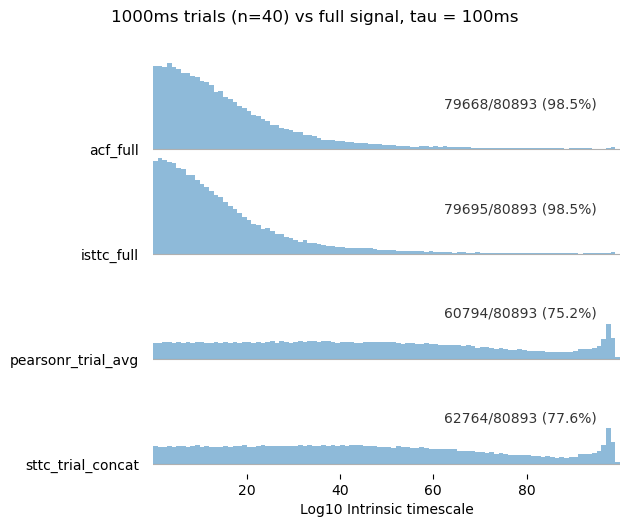

In [26]:
fig, axes = joypy.joyplot(data=tau_plot_long_df.query('tau_diff_rel >= 0 and tau_diff_rel <= 100'),
    by='method',
    column='tau_diff_rel',
    #range_style='own',
    ylim = 'max',
    grid="y",
    #kind='kde',
    hist=True, bins=100, fill=False,
    overlap=0.1,
    alpha=0.5,
    linewidth=1,
    x_range=[0,100]
)

#axes[-1].axvline(x=100, color='k', lw=0.5)

axes[-1].set_xlabel('Log10 Intrinsic timescale')
fig.suptitle('1000ms trials (n=40) vs full signal, tau = 100ms', y=1.05)


method_order = [
    'acf_full',
    'isttc_full',
    'pearsonr_trial_avg',
    'sttc_trial_concat',
]
for ax, method in zip(axes, method_order):
    tot    = tau_plot_long_0_100perc_df.at[method, 'total']
    inn    = tau_plot_long_0_100perc_df.at[method, 'in_range']
    pct    = tau_plot_long_0_100perc_df.at[method, 'percent_in_range']
    txt    = f"{inn}/{tot} ({pct})"
    # place in axis‐relative coords (x=95% from left, y=center)
    ax.text(
        0.95, 0.5, txt,
        transform = ax.transAxes,
        ha        = 'right',
        va        = 'center',
        fontsize  = 10,
        alpha     = 0.8
    )

if save_fig:
    plt.savefig(fig_folder + '100ms_5_methods_one_trial_impl_hist.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + '100ms_5_methods_one_trial_impl_hist.svg' , bbox_inches='tight')

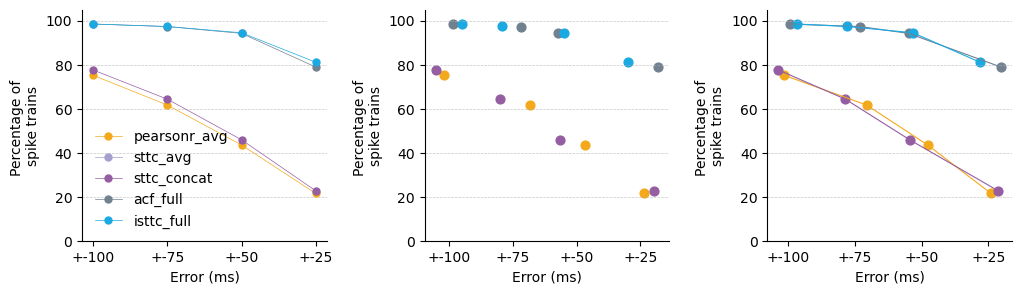

In [33]:
fig, axes = plt.subplots(1,3,figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_one_threshold(axes[0], tau_plot_error_long_df)

plot_one_threshold_jittered_lines(axes[1],
    tau_plot_error_long_df,
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[2],
    tau_plot_error_long_df,
    jitter=0.2, seed=42, plot_lines=True)

for ax in axes.flat:
    ax.set_ylabel('Percentage of \nspike trains')
    ax.set_xlabel('Error (ms)')
    ax.set_ylim([0, 105])
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False)


if save_fig:
    plt.savefig(fig_folder + 'taus_error_one_trials_impl.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_error_one_trials_impl.svg' , bbox_inches='tight')

#### Plot relative estimate error

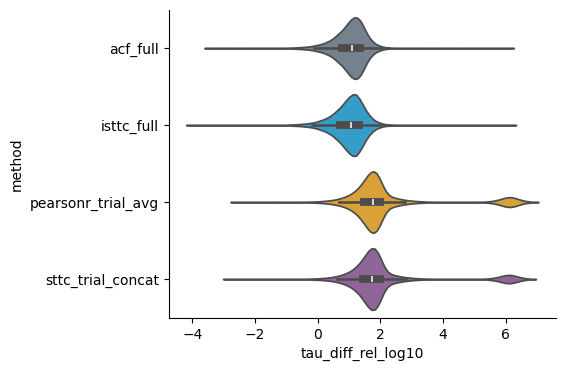

In [18]:
method_order = ['acf_full', 'isttc_full', 'pearsonr_trial_avg', 'sttc_trial_concat']
fig, axes = plt.subplots(1,1, figsize=(5, 4))

sns.violinplot(y='method', x='tau_diff_rel_log10', hue='method', order=method_order, hue_order=method_order, 
               palette=colors, data=tau_plot_long_df , cut=0, ax=axes)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + '100ms_5_methods_one_trial_impl_rel_error.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + '100ms_5_methods_one_trial_impl_rel_error.svg' , bbox_inches='tight')

#### Export for stats

In [ ]:
tau_concat_avg_df.to_csv(results_folder + 'tau_5methods_100trial_impl.csv')